# Анализ пользовательского поведения в мобильном приложении

Cтартап, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи мобильного приложения.

## Изучение общей информации

In [1]:
import pandas as pd
import math as mth
import seaborn as sns
from numpy import median
import datetime as dt
from scipy import stats as st
from matplotlib import pyplot as plt
from plotly import graph_objects as go
import plotly.io as pio

In [2]:
pd.options.display.max_columns = None
pio.renderers.default='png'
pio.renderers.scale = 0.8
pio.renderers.width = 500
pio.renderers.height = 350

In [3]:
df = pd.read_csv('logs_exp.csv', sep='\t')

display(df)
df.info()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


У столбца EventTimestamp необходимо сменить тип на дату.

## Подготовка данных

In [4]:
df['EventTimestamp'] = pd.to_datetime(df['EventTimestamp'], unit='s', errors='coerce')
df['date'] = df['EventTimestamp'].dt.strftime('%Y-%m-%d')

df.duplicated().sum()
df = df.drop_duplicates().reset_index(drop=True)

Заменили тип данных у EventTimestamp. Избавились от дубликатов.

In [5]:
df.columns = ['event', 'uid', 'ets', 'gr', 'date']

df.info()
display(df.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   event   243713 non-null  object        
 1   uid     243713 non-null  int64         
 2   ets     243713 non-null  datetime64[ns]
 3   gr      243713 non-null  int64         
 4   date    243713 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 9.3+ MB


,event,uid,ets,gr,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25
5,CartScreenAppear,6217807653094995999,2019-07-25 11:48:43,248,2019-07-25
6,OffersScreenAppear,8351860793733343758,2019-07-25 14:50:42,246,2019-07-25
7,MainScreenAppear,5682100281902512875,2019-07-25 20:14:37,246,2019-07-25
8,MainScreenAppear,1850981295691852772,2019-07-25 20:31:42,247,2019-07-25
9,MainScreenAppear,5407636962369102641,2019-07-26 03:35:12,246,2019-07-26


Привели столбец 'ets' к формату год-месяц-день-время. Создали отдельный столбец даты.

## Изучение и проверка данных

In [6]:
display(df['event'].value_counts())
print('Всего событий:')
print(df['event'].value_counts().sum())
print('Количество видов событий:')
print(df['event'].nunique())

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event, dtype: int64

Всего событий:
243713
Количество видов событий:
5


In [7]:
display(df['uid'].value_counts())
print('Всего пользователей:')
print(df['uid'].value_counts().sum())
print('Количество уникальных пользователей в логе:')
print(df['uid'].nunique())

6304868067479728361    2307
197027893265565660     1998
4623191541214045580    1768
6932517045703054087    1439
1754140665440434215    1221
                       ... 
395376432319166724        1
404128138074395619        1
6936517579657223951       1
5138854326043201424       1
3954096321632083010       1
Name: uid, Length: 7551, dtype: int64

Всего пользователей:
243713
Количество уникальных пользователей в логе:
7551


In [8]:
srsp = int(df.groupby('uid')['event'].agg('count').median())
print('В среднем на пользователя приходится событий:')
print(srsp)

В среднем на пользователя приходится событий:
20


<b>Данными за какой период вы располагаете?</b>

Минимальная дата:
2019-07-25
Максимальная дата:
2019-08-07


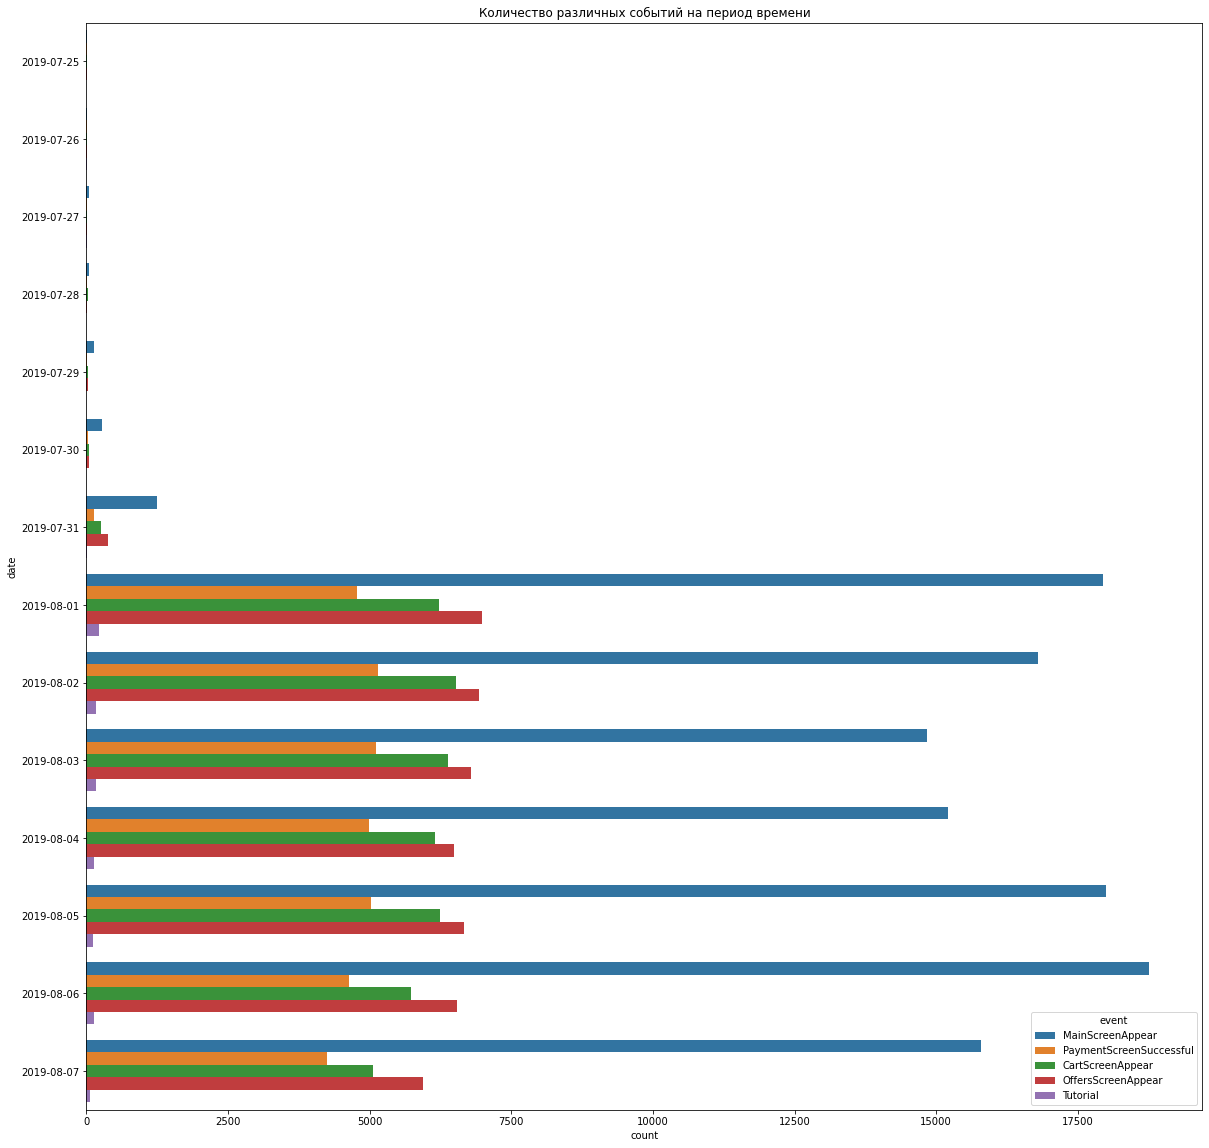

In [9]:
print('Минимальная дата:')
print(df['date'].min())
print('Максимальная дата:')
print(df['date'].max())

plt.figure(figsize=(20, 20))
ax = sns.countplot(y=df['date'], hue='event', data=df, dodge=True)
ax.set_title('Количество различных событий на период времени')
plt.show()

In [10]:
dfu = df['2019-07-31 21:00' <= df['date']]

print('Всего событий:')
print(dfu['event'].value_counts().sum())
print('Количество видов событий:')
print(dfu['event'].nunique())

print('Всего пользователей:')
print(dfu['uid'].value_counts().sum())
print('Количество уникальных пользователей в логе:')
print(dfu['uid'].nunique())

srsp = int(dfu.groupby('uid')['event'].agg('count').median())
print('В среднем на пользователя приходится событий:')
print(srsp)

Всего событий:
240887
Количество видов событий:
5
Всего пользователей:
240887
Количество уникальных пользователей в логе:
7534
В среднем на пользователя приходится событий:
19


Для дальнейшего исследования берём данные младше, чем 31 июля 2019 года 21:00.

<b>Много ли событий и пользователей вы потеряли, отбросив старые данные?</b>

In [11]:
print('Разница в событиях:')
print(df['event'].value_counts().sum() - dfu['event'].value_counts().sum())
print('')
print('Разница в уникальных пользователях:')
print(df['uid'].nunique() - dfu['uid'].nunique())

Разница в событиях:
2826

Разница в уникальных пользователях:
17


In [12]:
ggg = dfu.pivot_table(index=['gr'], values='uid', aggfunc=['count', 'nunique']).reset_index()
ggg.columns = ['y', 'count_uid', 'nunique_uid']
display(ggg['nunique_uid'])

0    2484
1    2513
2    2537
Name: nunique_uid, dtype: int64

Есть пользователи из всех 3 экспериментальных группп.

## Изучение воронки событий

In [13]:
dfu['event'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event, dtype: int64

In [14]:
evp = dfu.pivot_table(index=['event'], values='uid', aggfunc=['count', 'nunique']).reset_index()
evp.columns = ['count_uid', 'countuid', 'nunique_uid']
evp['%'] = evp['nunique_uid'] / dfu['uid'].nunique() * 100
evp = evp.sort_values(by='nunique_uid', ascending=False)
display(evp[['count_uid', 'nunique_uid', '%']])

,count_uid,nunique_uid,%
1,MainScreenAppear,7419,98.473586
2,OffersScreenAppear,4593,60.963632
0,CartScreenAppear,3734,49.561986
3,PaymentScreenSuccessful,3539,46.973719
4,Tutorial,840,11.149456


Столбец 'nunique_uid' - сколько пользователей совершали каждое из этих событий.

Столбец '%' - доля пользователей, которые хоть раз совершали событие.

Почти все пользователи видят главный экран, а вот с руководством ознакомились лишь 11 % от всех пользователей.

На первом шаге воронки мы не имеем конверсии 1. Это может быть связано с тех.проблемами, или у пользователя есть прямая ссылка на другой шаг. Также = не обязателен проход через все шаги.

<b>Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.</b>

MainScreenAppear - Появляется главный экран

→

OffersScreenAppear - Появляется экран предложений

→

CartScreenAppear - Появляется экран оплаты

→

PaymentScreenSuccessful - Экран оплаты успешно завершен

.............................................................................................................................

Tutorial - Руководство

<b>По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.</b>

Посетителей: 7419
Отношение посмотревших экран предложений к количеству посетителей: 56.62488205957676 %
Отношение дошедших до экрана оплаты к посмотревшим экран предложений: 42.06141394905975 %
Отношение посмотревших экран предложений к дошедшим до экрана оплаты: 25.693265421618563 %


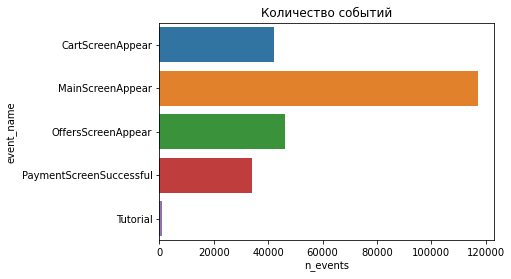

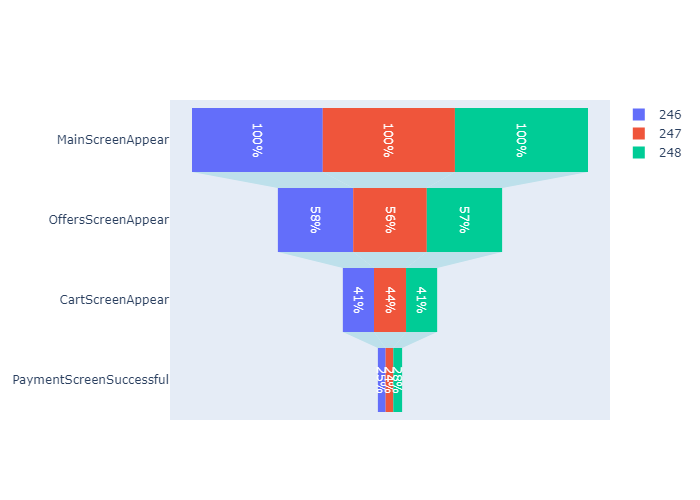

In [15]:
users = dfu.pivot_table(
    index='uid', columns='event', values='ets', aggfunc='min'
)

step_1 = ~users['MainScreenAppear'].isna()
step_2 = step_1 & (users['OffersScreenAppear'] > users['MainScreenAppear'])
step_3 = step_2 & (users['CartScreenAppear'] > users['OffersScreenAppear'])
step_4 = step_3 & (users['PaymentScreenSuccessful'] > users['CartScreenAppear'])

n_uid = users[step_1].shape[0]
wep = users[step_2].shape[0]
pay = users[step_3].shape[0]
n_payment = users[step_4].shape[0]

print('Посетителей:', n_uid)
print('Отношение посмотревших экран предложений к количеству посетителей:', (wep / n_uid) * 100, '%')
print('Отношение дошедших до экрана оплаты к посмотревшим экран предложений:', (pay / wep) * 100, '%')
print('Отношение посмотревших экран предложений к дошедшим до экрана оплаты:', (n_payment / pay) * 100, '%')

ev = dfu.groupby('event')['uid'].agg(['count', 'nunique']).reset_index()
ev.columns =['event_name', 'n_events', 'n_users']

event_pivot=dfu.pivot_table(index=['event','gr'], values='uid', aggfunc=['count', 'nunique']).reset_index()
event_pivot.columns = ['event_name', 'group', 'n_events', 'n_users']

zak = ev.sort_values('n_events', ascending=False).reset_index(drop=True)['event_name']
ax = sns.barplot(y='event_name', x='n_events', data=ev)
ax.set_title('Количество событий')
plt.show()

users = dfu[dfu['event'] != 'Tutorial'].pivot_table(
        index=['uid', 'gr'], 
        columns='event', 
        values='ets',
        aggfunc='min').reset_index()

groups = [246, 247, 248]

funnel ={}
for group in groups:
    funnel[group] =[]
    step_1 = (users['gr']==group) & (~users['MainScreenAppear'].isna())
    step_2 = step_1 & (users['OffersScreenAppear'] > users['MainScreenAppear'])
    step_3 = step_2 & (users['CartScreenAppear'] > users['OffersScreenAppear'])
    step_4 = step_3 & (users['PaymentScreenSuccessful'] > users['CartScreenAppear'])
    funnel[group].append(users[step_1].shape[0])
    funnel[group].append(users[step_2].shape[0])
    funnel[group].append(users[step_3].shape[0])
    funnel[group].append(users[step_4].shape[0])
   

fig = go.Figure()
for i, group in enumerate(groups):
    fig.add_trace(go.Funnel(
        name = str(group),
        y = (event_pivot[(event_pivot['group'] == group) & (event_pivot['event_name'] != 'Tutorial')]
             .sort_values('n_users', ascending=False)['event_name']),
        x = funnel[group],
        textposition = "inside",
        textinfo = "percent previous",
        constraintext='outside',
        textangle = 90,
        connector = {"fillcolor": '#bde0eb'},
        insidetextfont = {'color': 'white'}))

fig.show()

In [16]:
print('Посетителей:', n_uid)
print('Посмотрели экран предложений:', wep)
print('Разница между главным экраном и экраном предложений:', wep - n_uid)
print('Дошли до экрана оплаты:', pay)
print('Разница между экраном предложений и экраном оплаты:', pay - wep)
print('Оплатили:', n_payment)
print('Разница между экраном оплаты и оплатившими:', n_payment - pay)

Посетителей: 7419
Посмотрели экран предложений: 4201
Разница между главным экраном и экраном предложений: -3218
Дошли до экрана оплаты: 1767
Разница между экраном предложений и экраном оплаты: -2434
Оплатили: 454
Разница между экраном оплаты и оплатившими: -1313


На шаге между главным экраном и экраном предложений, теряется больше всего пользователей.

In [17]:
print('Доля пользователей дошедшая от первого события до оплаты:', (n_payment / n_uid) * 100, '%')

Доля пользователей дошедшая от первого события до оплаты: 6.119423102844049 %


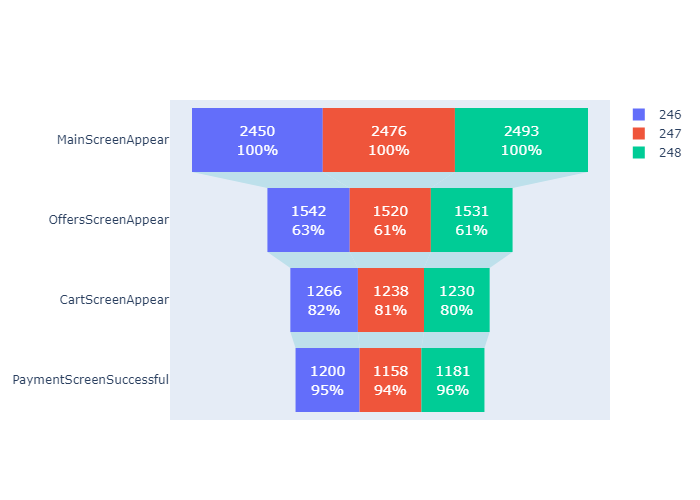

In [18]:
order = (ev[ev['event_name'] != 'Tutorial']
         .sort_values('n_events', ascending=False)['event_name']
         .reset_index(drop=True))

simple_funnel = {}
for group in groups:
    simple_funnel[group] =[]
    for event in order:
        simple_funnel[group].append(dfu[(dfu['gr'] == group) & (dfu['event'] == event)]['uid'].nunique())
fig = go.Figure()
for i, group in enumerate(groups):
    fig.add_trace(go.Funnel(
        name = str(group),
        y = (event_pivot[(event_pivot['group'] == group) & (event_pivot['event_name'] != 'Tutorial')]
             .sort_values('n_users', ascending=False)['event_name']),
        x = (event_pivot[(event_pivot['group'] == group) & (event_pivot['event_name'] != 'Tutorial')]
             .sort_values('n_users', ascending=False)['n_users']),
        textposition = "inside",
        textinfo = "value+percent previous",
        connector = {"fillcolor": '#bde0eb'},
        insidetextfont = {'color': 'white', 'size': 14}))

fig.show()

## Изучение результатов эксперимента

In [19]:
ggg2 = dfu.pivot_table(index=['gr'], values='uid', aggfunc=['nunique']).reset_index()
ggg2.columns = ['gr', 'nunique_uid']
display(ggg2[['nunique_uid']])

,nunique_uid
0,2484
1,2513
2,2537


<b>Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.</b>

<b>Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп.</b>

<b>Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?</b>

In [20]:
events = df.groupby('event')['uid'].agg(['count', 'nunique']).reset_index()
events.columns = ['event', 'n_events', 'n_users']

n_users = {'all': df['uid'].nunique(), 
           246: df[df['gr']==246]['uid'].nunique(),
           247: df[df['gr']==247]['uid'].nunique(),
           248: df[df['gr']==248]['uid'].nunique(),
           '246+247': df[(df['gr']==246) | (df['gr']==247)]['uid'].nunique()}

order = (events[events['event'] != 'Tutorial']
         .sort_values('n_events', ascending=False)['event']
         .reset_index(drop=True))

simple_funnel = {}
for group in groups:
    simple_funnel[group] = []
    for event in order:
        simple_funnel[group].append(df[(df['gr'] == group) & (df['event'] == event)]['uid'].nunique())

simple_funnel = pd.DataFrame(simple_funnel)

Проверяем гипотезу для каждого события, кроме 'Tutorial' по всем вариантам сравнения контрольных групп:

<b>H0: Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными</b>

<b>H1: Отвергаем нулевую гипотезу: между долями есть значимая разница</b>

In [21]:
simple_funnel['246+247'] = simple_funnel[246] + simple_funnel[247]
simple_funnel['event'] = order

colors =["#008000","#d1180a","#4682B4","#000000","#800080"]
sns.set_palette(sns.color_palette(colors))

def z_value_diff(first_group, second_group, alpha, color):
    for i in simple_funnel.index:
        alpha = alpha
        bonferroni_alpha = alpha / 4
        p1 = simple_funnel[first_group][i] / n_users[first_group]
        # пропорция успехов во второй группе:
        p2 = simple_funnel[second_group][i] / n_users[second_group]
        # пропорция успехов в комбинированном датасете:
        p_combined = ((simple_funnel[first_group][i] + simple_funnel[second_group][i]) / 
                      (n_users[first_group] + n_users[second_group]))
        # разница пропорций в датасетах
        difference = p1 - p2
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * 
                                        (1/n_users[first_group] + 1/n_users[second_group]))
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1) 
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        print('{} p-значение: {}'.format(simple_funnel['event'][i], p_value))
        if (p_value < bonferroni_alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        print('')
        
        fig = go.Figure()
    for i, group in enumerate([first_group, second_group]):
        fig.add_trace(go.Funnel(
            name = str(group),
            y = order,
            x = simple_funnel[group],
            textposition = "inside",
            textinfo = "value+percent initial",
            marker = {"color": colors[i+color]},
            connector = {"fillcolor": '#2F4F4F'},
            insidetextfont = {'color': 'white', 'size': 13}))

    fig.show()

<b>Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?</b>

MainScreenAppear p-значение: 0.5856639791209877
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.3233225048227193
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.19817540651836918
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.10902546202332886
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



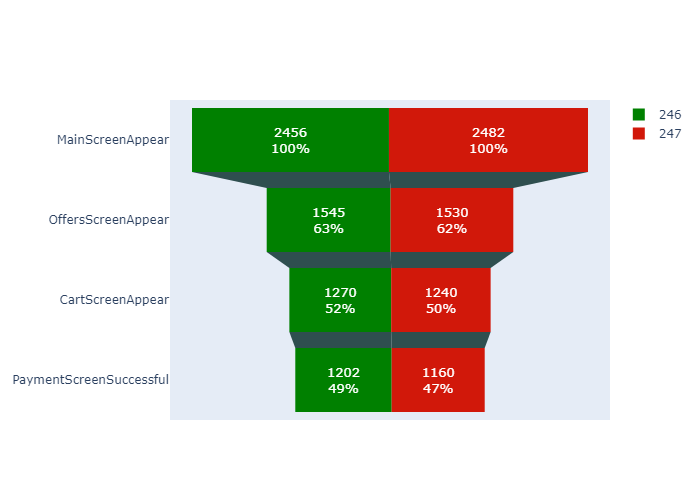

In [22]:
z_value_diff(246,247,0.05,0)

MainScreenAppear p-значение: 0.39774960182882513
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.2531656758489338
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.10534150642722295
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.23403912852637143
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



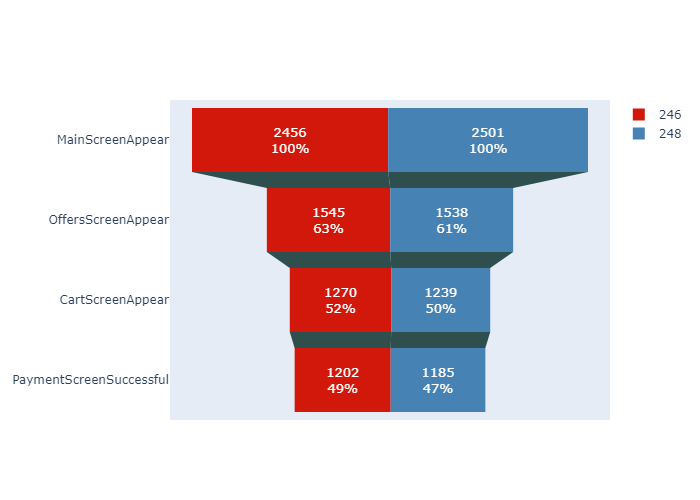

In [23]:
z_value_diff(246,248,0.05,1)

MainScreenAppear p-значение: 0.7632160970326178
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.878057445632423
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.7406094633808076
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.6763830984465451
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



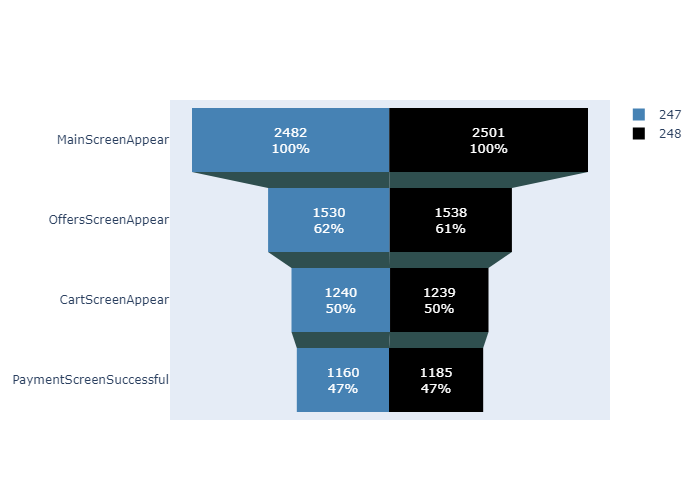

In [24]:
z_value_diff(247,248,0.05,2)

MainScreenAppear p-значение: 0.5067126962216841
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.4555404043137232
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.2609811882648243
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.6578429353593096
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



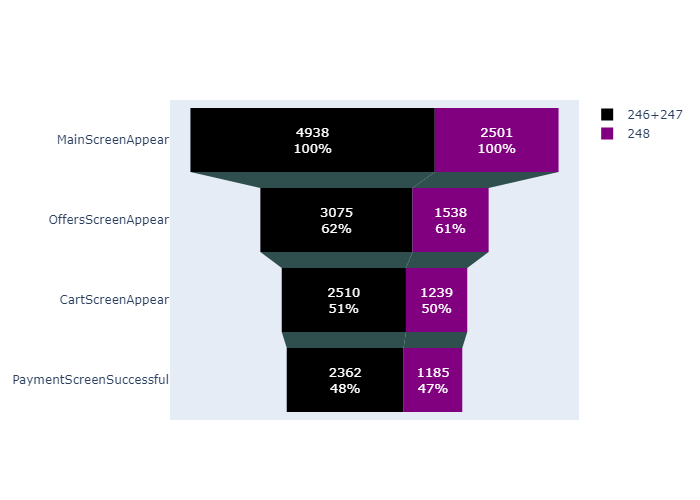

In [25]:
z_value_diff('246+247',248,0.05,3)

По итогам проверок - все группы являются равными по количеству.

<b>Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.</b>

Был выбран уровень значимости = 0.05. Сделано 16 проверок. Сделаем проверку статистических гипотез по уровню значимости = 0.1.

MainScreenAppear p-значение: 0.5856639791209877
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.3233225048227193
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.19817540651836918
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.10902546202332886
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



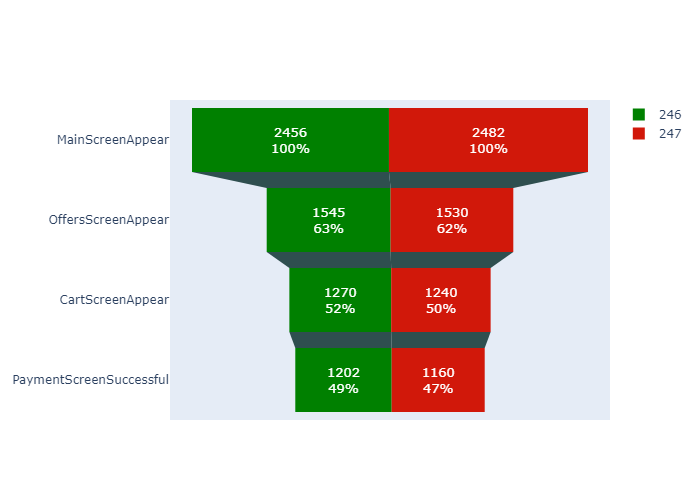

In [26]:
z_value_diff(246,247,0.1,0)

MainScreenAppear p-значение: 0.39774960182882513
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.2531656758489338
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.10534150642722295
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.23403912852637143
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



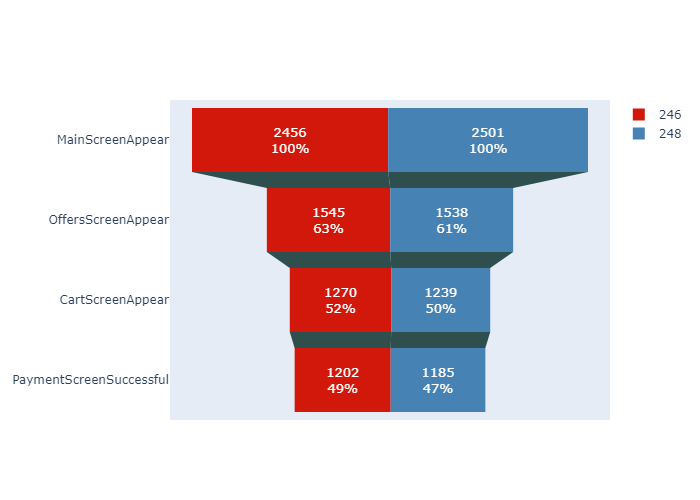

In [27]:
z_value_diff(246,248,0.1,1)

MainScreenAppear p-значение: 0.7632160970326178
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.878057445632423
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.7406094633808076
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.6763830984465451
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



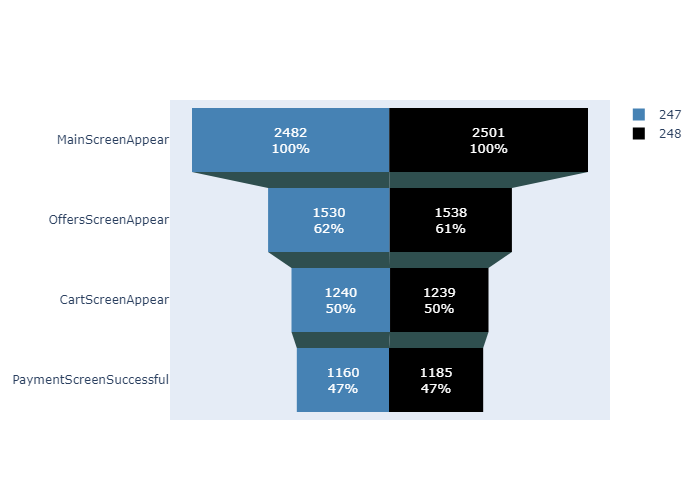

In [28]:
z_value_diff(247,248,0.1,2)

MainScreenAppear p-значение: 0.5067126962216841
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.4555404043137232
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.2609811882648243
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.6578429353593096
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



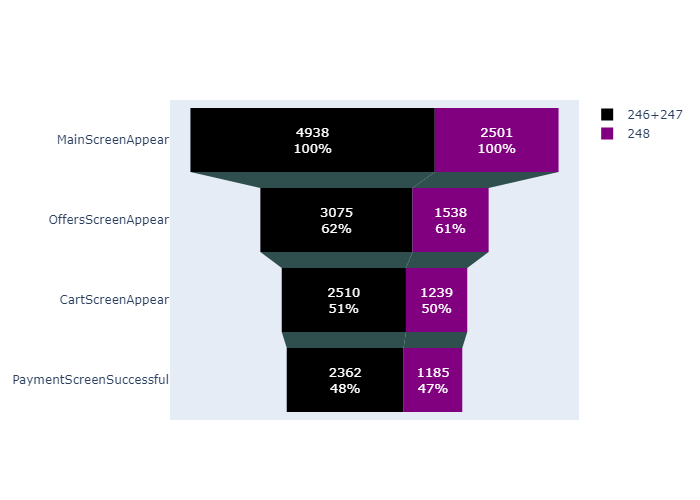

In [29]:
z_value_diff('246+247',248,0.1,3)

Сделано такое же количество проверок, различий между уровнями значимости 0.05 и 0.1 не найдено.

# Общий вывод

Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную "248" — с новыми.

В ходе работы было проверено влияние нового шрифта на пользователей, итог - новый шрифт значимо не повлиял на поведение пользователей. Можно оставлять старый или внедрить новый.

Также интересные факты:


- В среднем на пользователя приходится 19-20 событий.
- Доля пользователей дошедшая от первого события до оплаты: 6,1 % по последовательным действиям, а без них - 47 %.
- 98 % пользователей посмотрели главный экран, а вот с руководством ознакомились лишь 11 % от всех пользователей.
- На шаге между главным экраном и экраном предложений, теряется больше всего пользователей.